In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm
import copy

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
def HR_at_n(R,R_hat,R_exclude,n=10):
    #YOUR TASK: implement HR@n function
    R_hat = copy.copy(R_hat)
    R_hat[R_exclude>0] = -np.inf
    pred_items = np.argsort(-R_hat, axis=1)
    true_items = np.argsort(-R, axis=1)
    exclude_items_cnt = np.sum(R_exclude>0, axis=1)
    test_items_cnt = np.sum(R>0, axis=1)
    hr_total = 0
    for user_id in range(pred_items.shape[0]):
        min_end = min(n, pred_items.shape[1] - exclude_items_cnt[user_id])
        pred_items_for_user = pred_items[user_id, :min_end]
        propper_itemscnt_for_user = np.sum(np.in1d(pred_items_for_user, true_items[user_id, :test_items_cnt[user_id]]))
        if test_items_cnt[user_id]>0:
            hr_for_user = propper_itemscnt_for_user/min(n,test_items_cnt[user_id])
            hr_total += hr_for_user
    hr_total /= np.shape(R)[0]
    return hr_total

In [8]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
from torch.utils.data import random_split
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
#train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

cv_k = 5

total_length = len(ds_train)
subset_sizes = [total_length // cv_k] * cv_k
subset_sizes[-1] += total_length % cv_k
#subset_datasets = random_split(train_dl.dataset, subset_sizes)
#subset_dataloaders = [DataLoader(dataset, batch_size=16*1024, shuffle=True) for dataset in subset_datasets]
subset_datasets = random_split(ds_train, subset_sizes)

params = {
    'mf_dim': [8, 16],
    'mlp_layer_sizes': [[128, 64], [128, 64, 32]],
    'learning_rate': [0.01, 0.001],
    'dropout': [0.3, 0.5]
}

results = pd.DataFrame()
for mf_dim in params['mf_dim']:
    for mlp_layer_sizes in params['mlp_layer_sizes']:
        for learning_rate in params['learning_rate']:
            for dropout in params['dropout']:
                cv_loss = []
                for k in range(cv_k):

                    train_dl = DataLoader(subset_datasets[k], batch_size=16*1024, shuffle=True)
                    
                    model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)
                    criterion = nn.BCELoss()
                    optimizer = Adam(model.parameters(), lr= learning_rate)
                    test_loss = []
                    train_loss = []

                    for epoch in range(50):
                        model.train()
                        tr_loss=[]
                        print("Traininng "+str(epoch))
                        for (u,i,l) in tqdm.tqdm(train_dl):
                            # clear the gradients
                            optimizer.zero_grad()
                            # compute the model output
                            yhat = model(u,i,sigmoid=True)
                            l = l.unsqueeze(1)
                            # calculate loss
                            loss = criterion(yhat, l)
                            tr_loss.append(loss.detach().numpy())
                            # credit assignment
                            loss.backward()
                            # update model weights
                            optimizer.step()
                        train_loss.append(np.mean(tr_loss))
                        model.eval()
                        predictions = []
                        with torch.no_grad():
                            t_loss=[]
                            for i, (u,i,l) in enumerate(test_dl):
                                yhat = model(u, i, sigmoid=True)
                                predictions.append(yhat)
                                l = l.unsqueeze(1)
                                tl = criterion(yhat, l)
                                t_loss.append(tl) 
                            test_loss.append(np.mean(t_loss))

                    cv_loss.append(test_loss)
                cv_loss_avg = np.mean(cv_loss)

                current_run = pd.DataFrame.from_dict({'mf_dim' : [mf_dim], 'mlp_layer_sizes' : [mlp_layer_sizes], 
                                                      'learning_rate' : [learning_rate], 'dropout' : [dropout], 'loss' : [cv_loss_avg]})
                results = pd.concat([results, current_run])

Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.91it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.94it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.52it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.90it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.75it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.91it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.91it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.94it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.91it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.70it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.65it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.95it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.91it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.90it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.48it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.06it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.58it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.70it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.75it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.52it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.29it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.17it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  3.00it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.58it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.37it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.75it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.48it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.30it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.48it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.92it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.06it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.58it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.37it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.31it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.94it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.90it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.94it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.95it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.40it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.60it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.43it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.44it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.56it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.59it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.34it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.36it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.78it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.70it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.61it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.74it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.53it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.57it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.21it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.76it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.68it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.82it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.71it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.32it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.51it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.81it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.75it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.73it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.13it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.77it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.20it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.38it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.41it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.89it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.47it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.64it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.72it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.93it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.79it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.80it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.17it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.37it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.67it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.58it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.22it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.62it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.54it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.65it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.07it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.30it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.65it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.52it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.04it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.48it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.58it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.04it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.65it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.27it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.91it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.42it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.29it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.00it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.17it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.98it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.18it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Traininng 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 1


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


Traininng 2


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]


Traininng 3


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]


Traininng 4


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 5


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


Traininng 6


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


Traininng 7


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 8


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


Traininng 9


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.06it/s]


Traininng 10


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]


Traininng 11


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


Traininng 12


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]


Traininng 13


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Traininng 14


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.15it/s]


Traininng 15


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


Traininng 16


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.35it/s]


Traininng 17


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]


Traininng 18


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]


Traininng 19


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]


Traininng 20


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]


Traininng 21


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.85it/s]


Traininng 22


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]


Traininng 23


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.33it/s]


Traininng 24


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Traininng 25


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


Traininng 26


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]


Traininng 27


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]


Traininng 28


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.19it/s]


Traininng 29


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


Traininng 30


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 31


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]


Traininng 32


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]


Traininng 33


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


Traininng 34


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.48it/s]


Traininng 35


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]


Traininng 36


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]


Traininng 37


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]


Traininng 38


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]


Traininng 39


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


Traininng 40


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]


Traininng 41


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 42


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.26it/s]


Traininng 43


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


Traininng 44


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


Traininng 45


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


Traininng 46


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


Traininng 47


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]


Traininng 48


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


Traininng 49


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


In [9]:
results.where(results.loss == min(results.loss)).dropna()

,mf_dim,mlp_layer_sizes,learning_rate,dropout,loss
0,8.0,"[128, 64]",0.001,0.5,0.542406


In [169]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)


model = NeuMF(users_num, movies_num, 8, [128,64], dropout= 0.5)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
test_loss = []
train_loss = []
test_hr = []
train_hr = []
for epoch in range(50):
    model.train()
    tr_loss = []
    tr_hr = []
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        hr_tr = HR_at_n(np.array(l), yhat.detach().numpy(), np.zeros_like(l))
        tr_hr.append(hr_tr)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    train_loss.append(np.mean(tr_loss))
    train_hr.append(np.mean(tr_hr))
    
    model.eval()
    with torch.no_grad():
        t_loss=[]
        t_hr = []
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl)
            hr = HR_at_n(l.numpy(), yhat.numpy(), np.zeros_like(yhat))
            t_hr.append(hr)
            true_labels.append(l)
            
        test_loss.append(np.mean(t_loss))
        test_hr.append(np.mean(t_hr))

Traininng 0


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.58it/s]


Traininng 1


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]


Traininng 2


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.51it/s]


Traininng 3


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.66it/s]


Traininng 4


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.60it/s]


Traininng 5


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.57it/s]


Traininng 6


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.69it/s]


Traininng 7


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]


Traininng 8


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


Traininng 9


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.72it/s]


Traininng 10


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]


Traininng 11


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.74it/s]


Traininng 12


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


Traininng 13


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.56it/s]


Traininng 14


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.62it/s]


Traininng 15


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


Traininng 16


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.67it/s]


Traininng 17


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


Traininng 18


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]


Traininng 19


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.67it/s]


Traininng 20


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.73it/s]


Traininng 21


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.74it/s]


Traininng 22


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]


Traininng 23


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]


Traininng 24


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.37it/s]


Traininng 25


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 26


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 27


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]


Traininng 28


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 29


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 30


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.36it/s]


Traininng 31


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 32


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Traininng 33


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.40it/s]


Traininng 34


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 35


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.53it/s]


Traininng 36


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 37


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.31it/s]


Traininng 38


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.36it/s]


Traininng 39


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


Traininng 40


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.73it/s]


Traininng 41


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


Traininng 42


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]


Traininng 43


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.74it/s]


Traininng 44


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.69it/s]


Traininng 45


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]


Traininng 46


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.73it/s]


Traininng 47


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.73it/s]


Traininng 48


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.74it/s]


Traininng 49


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.74it/s]


### Plot results

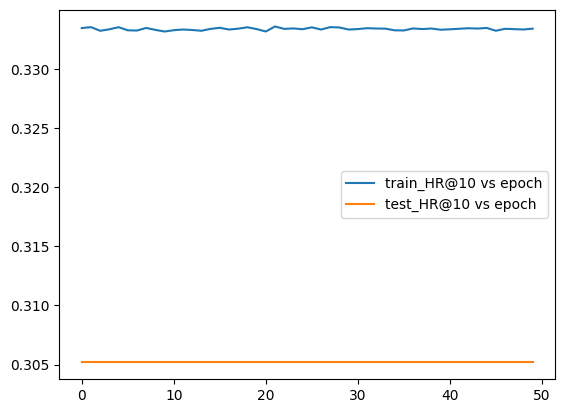

In [172]:
plt.plot(train_hr,label='train_HR@10 vs epoch')
plt.plot(test_hr,label='test_HR@10 vs epoch')
plt.legend()
plt.show()

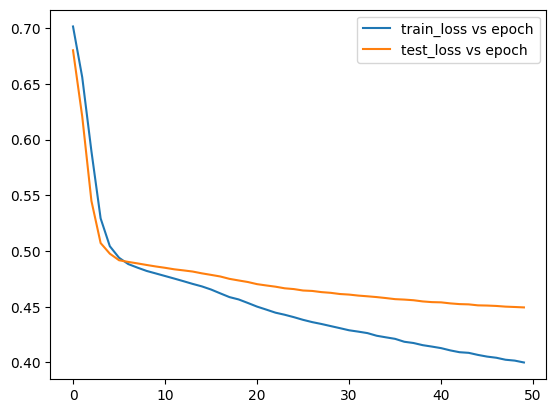

In [173]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()